In [1]:
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
X_train = pd.read_csv('train.csv')

In [3]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## *DATA EXPLORATION*

<AxesSubplot:xlabel='Survived', ylabel='count'>

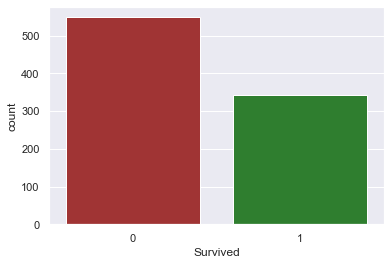

In [5]:
sns.countplot(x = 'Survived', palette= ["firebrick","forestgreen"], data = X_train)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

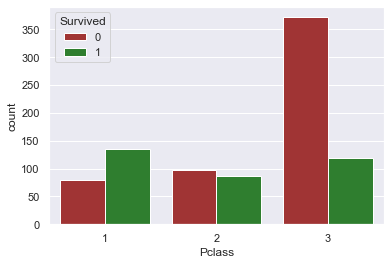

In [6]:
sns.countplot(x = 'Pclass',hue = 'Survived', palette= ["firebrick","forestgreen"], data = X_train)

### Passengers in the 1st Class were most likely to survived than the other Classes
### Passengers in the 3rd class has less than 1/3 chance of surviving in the tragedy

<AxesSubplot:xlabel='Sex', ylabel='count'>

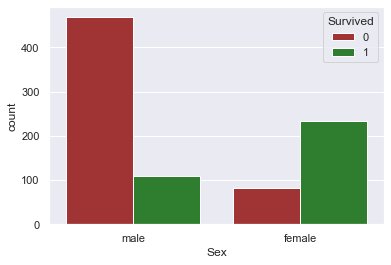

In [7]:
sns.countplot(x = 'Sex',hue = 'Survived', palette= ["firebrick","forestgreen"], data = X_train)

### The females were 2 times likely to be survived than males even though the number of females are around half of the number of male passengers

<AxesSubplot:xlabel='Embarked', ylabel='count'>

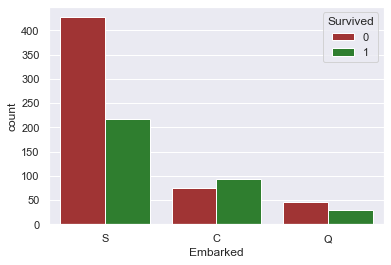

In [8]:
sns.countplot(x = 'Embarked',hue = 'Survived', palette= ["firebrick","forestgreen"], data = X_train)

### The passengers who Embarked at 'C' are most survived when compared to the passengers who Embarked at "S" and "Q"

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

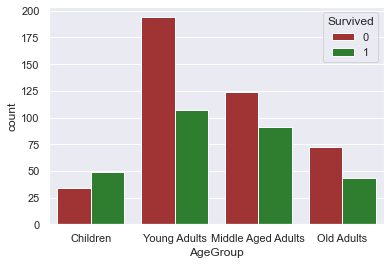

In [9]:
viz_df = X_train.copy()
labels = ['Children','Young Adults','Middle Aged Adults','Old Adults']
viz_df['AgeGroup'] = pd.cut(viz_df['Age'], bins=[0,16,30,45,110], labels=labels, right=False)
sns.countplot(x = 'AgeGroup', hue = 'Survived', data = viz_df, palette= ["firebrick","forestgreen"])

### Children are the most survived age group in the tragedy when compared to the other age groups
### Young adults group has the low survived rate

<AxesSubplot:xlabel='Relatives', ylabel='count'>

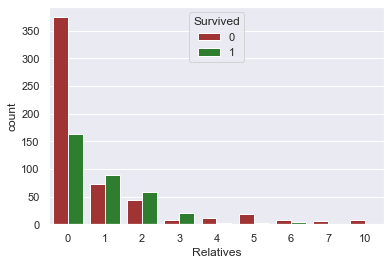

In [10]:
viz_df['Relatives'] = viz_df['SibSp']+viz_df['Parch']
sns.countplot(x = 'Relatives', hue = 'Survived', palette= ['firebrick','forestgreen'], data = viz_df)

<AxesSubplot:>

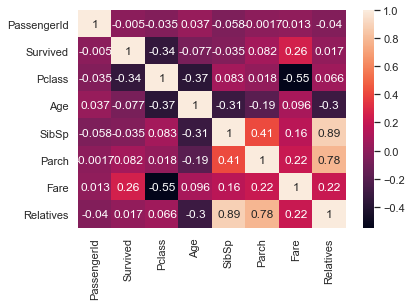

In [11]:
sns.heatmap(viz_df.corr(), annot = True)

### From the above heat map we can observe that the passenger survival is more correlated with the Fare column, when compared to the other features

## *DATA PREPROCESSING*

In [12]:
def preprocessing(df):
    
    # Combining SibSP and Parch columns to relatives column
    
    df['Relatives'] = df['SibSp']+df['Parch']
    
    # Some instances are missing Age attribute, imputing the ages by group the passengers by their name prefix and taking the median age value of each group
    
    df['Name'][2].split(',')[1].split()[0]
    prefix = []
    for _ in df['Name']:
        prefix.append(_.split(',')[1].split()[0])
    df['Prefix'] = prefix    
    df.loc[(df.Age.isnull())&(df.Prefix=='Mr.'),'Age']=df[df['Prefix'] == 'Mr.']['Age'].mean()
    df.loc[(df.Age.isnull())&(df.Prefix=='Mrs.'),'Age']=df[df['Prefix'] == 'Mrs.']['Age'].mean()
    df.loc[(df.Age.isnull())&(df.Prefix=='Miss.'),'Age']=df[df['Prefix'] == 'Miss.']['Age'].mean()
    df.loc[(df.Age.isnull())&(df.Prefix=='Master.'),'Age']=df[df['Prefix'] == 'Master.']['Age'].mean()
    
    # dropping the columns which are not useful for training the model
    
    df.drop(columns = ['PassengerId','Name','Ticket','Cabin','Prefix','SibSp','Parch'],inplace = True)
    df['Age'].fillna(df['Age'].median(),inplace = True)
    
    # One-hot encodeing the Embarked category column
    
    df['Embarked'].fillna(df['Embarked'].mode()[0],inplace = True)
    
    # Converting the Sex column to binary attribute column
    
    df['Sex'].replace({'male':1,'female':0},inplace = True)
    
    # Normalizing the values using Min-Max normalization
    
    min_ = df['Age'].min()
    max_ = df['Age'].max()
    df['scaled_Age'] = df['Age'].map(lambda x: (x-min_)/(max_- min_))
    min_ = df['Fare'].min()
    max_ = df['Fare'].max()
    df['scaled_Fare'] = df['Fare'].map(lambda x: (x-min_)/(max_- min_))
    dummy = pd.get_dummies(df['Embarked'], drop_first = True)
    df.drop(columns = ['Embarked','Age','Fare'], inplace = True)
    df = pd.concat([df,dummy],axis = 1)
    return df

In [13]:
X_train = preprocessing(X_train)                             # Preprocessing the training data

In [14]:
y_train = X_train['Survived'] # y_train data
X_train.drop(columns = ['Survived'], axis = 1, inplace = True)  # X_train data

In [15]:
test = pd.read_csv('test.csv')
x_test = test.copy()
X_test = preprocessing(x_test)                                  # Preprocessing the training data

<div>
<img src="attachment:sigmoid.png" width="500"/>
</div>

## BUILDING THE LOGISTIC REGRESSION ALGORITHM FROM SCRATCH

In [16]:
def sigmoid_fun(x):
    return (1/(1+np.exp(-x)))
def log_regression(X_train, y_train,X_test, learning_rate = 0.0001, iterations = 100000):
    X_train = np.hstack((np.ones((X_train.shape[0], 1)),X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)),X_test))
    y = y_train
    m,n = X_train.shape
    tetha = np.append(1,np.random.uniform(0,1,[n-1]))
    for i in range(iterations):
        lin_regress = np.dot(X_train,tetha)
        y_predict = sigmoid_fun(lin_regress)
        error = y_predict-y
        d_tetha = (1/m)*np.dot(X_train.T,error)
        tetha = tetha - (learning_rate * d_tetha)
    lin_regress = np.dot(X_test,tetha)
    sigmoid = sigmoid_fun(lin_regress)
    y_predicted = [0 if _<0.5 else 1 for _ in sigmoid ]
    return np.array(y_predicted)

In [17]:
y_pred = log_regression(X_train,y_train,X_test,5e-2,400000) # predicting by applying logistic regression

### Converting the output to csv file

In [18]:
submission_output = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':y_pred})
print(f'Head of the submission file is :\n\n{submission_output}')
filename = 'TitanicPredictions_submission.csv'
submission_output.to_csv(filename,index=False)

Head of the submission file is :

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


## KAGGLE USERNAME - ADS245_0398 / SAINATH REDDY V

# KAGGLE SCORE    $\;\;\;\;$    - 77.511%
<img src='Screenshot 2020-11-30 163215.jpg'/>
<br>

# <center>REPORT
The data exploration part is explanied in the below the visualization part.
### PREPROCESSING AND FEATURE SELECTION
    1. PassengerId, Ticket and Cabin features were dropped because they either have large missing values or do not help in building the model.<br>
    2. Around 20% percent of values are missing in the Age feature, so imputation of missing values is done by taking the average age by grouping the passengers by their name prefix(like Mr., Mrs., Miss. etc).<br>
    3. The SibSp and Parch columns are combined into a single feature called 'Reatives' column.<br>
    4. Sex and Embarked features are encoded using one-hot encoding method.
    5. Finally, the Age feature is normalized using MinMax scaler.
    
# <center>*LOGISTIC REGRESSION*
The predictions of the titanic dataset are binary classifiers (0 – not survived, 1 – Survived). So, I have chosen the Logistic regression Algorithm to build a model.<br>
Logistic Regression takes the advantage of Sigmoid function to convert the linear regression equation output between 0 and 1. <br>
<br>
$$
0 \leq h_(x) \leq 1
$$
where $$
h(x)=\frac{1}{1+e^{-\theta^{\top} x}}
$$
<img src='sigmoid.png' style = "width:200px;height:200px"/>
<center> Sigmoid Function</center>
<br>
If we use the linear regression cost function, then we get a non-convex function with many local minima and it is not possible to reduce the cost function to a global minima using gradient descent. So, the cost function of the logistic regression is as follows

$$
 cost(h(x), y)=\left\{\begin{array}{ll}
-\log (h(x)) & \text { if } y=1 \\
-\log (1-h(x)) & \text { if } y=0
\end{array}\right.
$$
<br>
The above cost function can be rewritten as
$$
\operatorname{cost}(h(x), y)=-y \log (h(x))-(1-y) \log (1-h(x))
$$
<br>
<br>
<br>
The above cost function can be reduced by using gradient descent.<br>
<br>
To minimize the cost function 
$$
\min J(\theta) \Rightarrow \theta_{j}=\theta_{j}-\alpha \frac{\partial}{\partial \theta_{j}} J(\theta)
$$
$$
\begin{aligned}
\text { where } \frac{\partial}{\partial \theta_{j}} J(\theta) &=\frac{1}{m} \sum_{i=1}^{m}(h(x)-y) x_{j} \\
& m=\text { number of instances }
\end{aligned}
$$
    
   <br>
    <br>
    <br>
    
## PSUEDO CODE
    
    step 1: Define a parameter vector (tetha) of size (no of features) and assign a random values between 0 and 1.
    step 2: Dot product the tetha and X_train datasets.
    step 3: Apply the sigmoid function to the above result.
    step 4: find error value(y_predict - y)
    step 5: Apply the gradient descent.
    Step 6: repeat step 2 to step 5 untill all iterations are completed.
    step 7: predict the values for the test data by applying dot multiplication to X_test and tetha.
    step 8: apply sigmoid function to the result and make a threshold to classify into groups.
<br>
    <br>
    <br>
    
# RESULT
  ##  The obtained accuracy on the titanic test data is 77.511%.